In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans

from utils import *

# Customer segmentation (RFM analysis)

RFM analysis is a marketing technique used to quantitatively rank and group customers based on the recency, frequency and monetary total of their recent transactions to identify the best customers and perform targeted marketing campaigns. The system assigns each customer numerical scores based on these factors to provide an objective analysis. RFM analysis is based on the marketing adage that "80% of your business comes from 20% of your customers."

RFM analysis ranks each customer on the following factors:

- Recency: How recent was the customer's last purchase? Customers who recently made a purchase will still have the product on their mind and are more likely to purchase or use the product again. Businesses often measure recency in days. But, depending on the product, they may measure it in years, weeks or even hours;
- Frequency: How often did this customer make a purchase in a given period? Customers who purchased once are often are more likely to purchase again. Additionally, first time customers may be good targets for follow-up advertising to convert them into more frequent customers;
- Monetary value: How much money did the customer spend in a given period? Customers who spend a lot of money are more likely to spend money in the future and have a high value to a business.

*Source:* [SearchDataManagement](https://searchdatamanagement.techtarget.com/definition/RFM-analysis)

Just like before, we'll be using the datasets from Group 1 as the basis for our visualizations and analyses. Visualizations for the other groups can be seen in the Streamlit app.

In [2]:
# Group 1:
# items1 = pd.read_csv('data/Created in part 01/group1_items.csv', index_col='Invoice', parse_dates=['InvoiceDate'])
invoices = pd.read_csv('../data/Created in part 01/group1_invoices.csv', index_col='Invoice', parse_dates=['InvoiceDate'])

And now all that preprocessing from part 02:

In [3]:
invoices = (
    invoices
    .pipe(adjust_time_window)
    .pipe(normalize_invoicedate)
    .pipe(clean_customer_id)
)

invoices.head(3)

,Quantity,Price,Customer ID,InvoiceDate
Invoice,,,,
496349,228,65.51,14739,2010-01-02
496351,79,80.05,14370,2010-01-02
496354,98,25.61,12810,2010-01-02


___
- # Recency

How recent was the customer's last purchase?

Let's start by creating a new df (`invoices_by_user`) that will hold all relevant information from each unique customer.

In [4]:
invoices_by_user = pd.DataFrame({'CustomerID': invoices['Customer ID'].unique()})

Now we add the date of the last purchase of each customer, as a new column named `MaxPurchase`, and then merge it with the previously created df.

In [5]:
invoices_max_date = (
    invoices
    .groupby('Customer ID')
    ['InvoiceDate']
    .max()
    .rename('MaxPurchase')
)

invoices_by_user = invoices_by_user.merge(invoices_max_date, left_on='CustomerID', right_on='Customer ID')

invoices_by_user.head(3)   # checking if everything's alright

,CustomerID,MaxPurchase
0,14739,2010-10-31
1,14370,2010-09-15
2,12810,2010-06-23


Using the most recent purchase (max value of `MaxPurchase`) as reference, we can compare how recent the other purchases are (in days).

In [6]:
invoices_by_user['Recency'] = (invoices_by_user['MaxPurchase'].max() - invoices_by_user['MaxPurchase']).dt.days

Plotting that in a histogram...

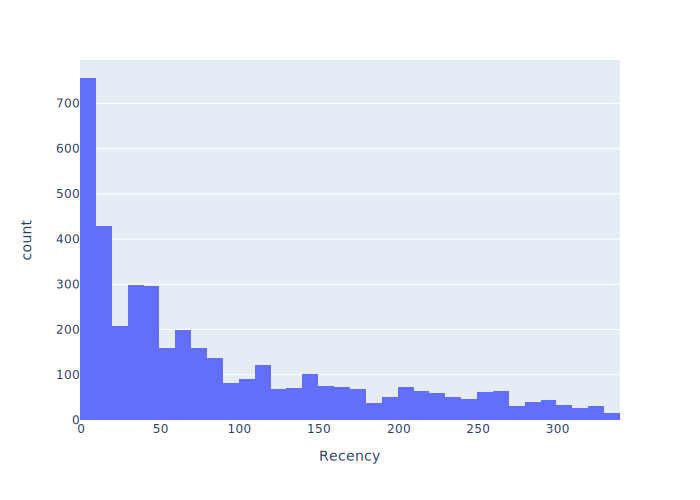

In [7]:
fig = px.histogram(data_frame=invoices_by_user, x='Recency')
fig.show('svg')

Good, we have a lot of customers that made their last purchase in the previous 60 days. That might seem like good news, but it doesn't tell us much about the generate revenue from these purchases...

Perhaps we can *group* these customers into clusters? *Grouping* in machine learning lingo usually means *clustering* things. And that's exactly what we are doing next.

For that, we'll be using the classical [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) (a.k.a. *segmentation*).

The first step is to define what is the optimal value of *k*, i.e., how many clusters should we divide our customers into?

That question is usually answered in one of the following ways:

1. Graphically (the elbow method);
2. Mathematically (using a formula that calculates the shortest distance between a point in space and a line).

Obviously, we are gonna cover both methods! Let's press on.

## The elbow method

This is one of the most common and technically robust methods. This is based on principle that while clustering performance as measured by WCSS (within-cluster sum of squares) increases (i.e. WCSS decreases) with increase in *k*, rate of increase is usually decreasing. So performance improvement for increasing number of cluster from, say, 3 to 4 is higher than that for increasing from 4 to 5.

Plotting WCSS against increasing *k* can show an ‘elbow’ which demarks significant drop in rate of increase. Selecting number of clusters corresponding to elbow point achieves reasonable performance without having too many clusters. This is still judgmental since what constitutes elbow is visually determined. Further, in practice, there may not be an elbow but smooth curve, or, there may be more than one elbow.

*Source:* [EduPristine](https://www.edupristine.com/blog/beyond-k-means)

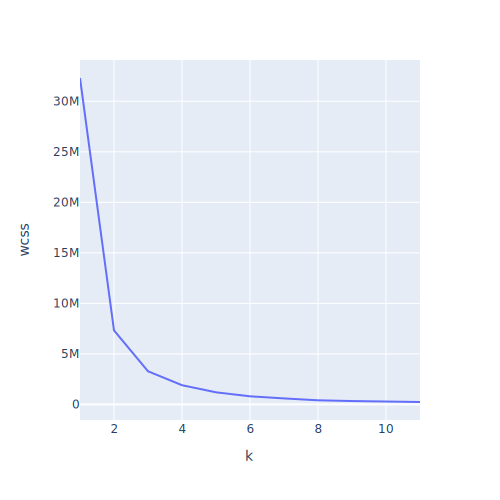

In [8]:
wcss={}   # withing-clusters sum of squares -> we want this to be as low as possible
y = invoices_by_user[['Recency']]   # our target for clustering

for i in range(1, 12):   # analyzing the wcss for each case from k=1 to k=12
    kmeans = KMeans(n_clusters=i, max_iter=500).fit(y)   # fitting our data into `i` clusters
    wcss[i] = kmeans.inertia_   # saving the wcss of each run in a dictionary, in the format: key=`i`, value=`obtained wcss`

fig = px.line(x=wcss.keys(), y=wcss.values(), width=500, labels={'x': 'k', 'y': 'wcss'})   # plotting keys and values
fig.show('svg')

We clearly see the *elbow* of the curve at k = 3.

## The "mathematic" method

[Jessica Temporal](https://github.com/jtemporal) has an amazing article on this! I highly suggest you check it out, by clicking [here](https://jtemporal.com/kmeans-and-elbow-method/).

The following functions were taken from her article. All credits to her!

In [9]:
# Thanks, Jessica!

def calculate_wcss(data):
    wcss = []
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)
    return wcss

def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]
    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = np.abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    return distances.index(max(distances)) + 2

Phew, that was a lot of code. Let's see how it goes

In [10]:
optimal_number_of_clusters(calculate_wcss(invoices_by_user['Recency'].values.reshape(-1,1)))

5

The elbow methods says 3, but this other one says 5.

The more the merrier, and since our dataset is small, no extra computational effort will be needed if we pick k = 5 instead of 3.

5, it is!

In [11]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(invoices_by_user[['Recency']])
invoices_by_user['RecencyCluster'] = kmeans.predict(invoices_by_user[['Recency']])   # create a column with customer's clusters

In [12]:
invoices_by_user.groupby('RecencyCluster').describe()   # checking how those clusters behave

Recency                                                     \
                 count        mean        std    min    25%    50%    75%   
RecencyCluster                                                              
0               1656.0   14.141908  11.189109    0.0    5.0   12.0   23.0   
1                453.0  202.317881  22.242142  165.0  186.0  204.0  221.0   
2               1005.0   60.567164  15.664584   39.0   46.0   61.0   74.0   
3                385.0  281.862338  26.239070  244.0  259.0  279.0  303.0   
4                621.0  126.624799  20.318654   95.0  110.0  125.0  144.0   

                       
                  max  
RecencyCluster         
0                37.0  
1               242.0  
2                93.0  
3               332.0  
4               163.0

It is tempting to draw conclusions right from the `count` column, but our target here is `min` and `max`!

`min` and `max` show us the range of days of each cluster. Obviously, the cluster which ranges from `min = 0` to `max = ~37` is the "best" one.

However, those clusters are looking weird. Everytime we run the prediction method from the k-means model, the labels of the clusters change... They are still the same clusters, but they are assigned different labels on each run (i.e., cluster 4 might become cluster 2, cluster 1 might become cluster 0, etc.).

We definitely need a helper function to normalize this.

*HINT:* For Frequency and Monetary value, this same issue with cluster labeling will occur. Therefore, let's make this function as generic as possible so it can work for all 3 cases.

In [13]:
def sort_cluster(df, target_section):
    """
    Normalize cluster ordering.
    
    Sorts cluster labelling from best (4) to worst (0). 

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe containing `target_column`.
    target_section : {'Recency', 'Frequency', 'Monetary'}
        Section where normalization must be applied to.

    Returns
    -------
    pandas.DataFrame
        Normalized dataframe.
    """
    normalized_df = df.copy()   # so that we don't mess our original df!
    # Assigns the target column to normalize
    target_column = target_section + 'Cluster'
    # Generates the .describe() df, selects the innermost columns of the MultiIndex and selects only `min` (returns a pd.Series)
    from_describe = normalized_df.groupby(target_column).describe().xs(target_section, axis=1)['min']
    # Sorts Series values (`min`) in ascending order, grabs the index of this new sorted Series and passes it to a list.
    sorted_index = from_describe.sort_values().index.tolist()
    # Replaces the order of clusters in `sorted_index` for our desired order: from 0 to 4
    # But there's a catch here!
    # For Recency, the lowest the better, because it means our customers made recent purchases
    # For Frequency and Monetary value, however, the greater the better. High frequency and high expenditures are good for us!
    # To keep consistency between clusters (so that 0 is always worst and 4 is always best), we need to sort according to the section
    if target_section == 'Recency':
        normalized_df[target_column] = normalized_df[target_column].replace(sorted_index, [4, 3, 2, 1, 0])
    else:
        normalized_df[target_column] = normalized_df[target_column].replace(sorted_index, [0, 1, 2, 3, 4])
    return normalized_df

# Amazing, this is going straight to `utils.py`!

Now that we have a helper function that can sort the clusters in whichever order they are generated, we can pass it to our main df.

Let's do it and then check if we get the same clusters from the previous df generated with `.describe()`.

In [14]:
invoices_by_user = sort_cluster(invoices_by_user, 'Recency')

invoices_by_user.groupby('RecencyCluster').describe()

Recency                                                     \
                 count        mean        std    min    25%    50%    75%   
RecencyCluster                                                              
0                385.0  281.862338  26.239070  244.0  259.0  279.0  303.0   
1                453.0  202.317881  22.242142  165.0  186.0  204.0  221.0   
2                621.0  126.624799  20.318654   95.0  110.0  125.0  144.0   
3               1005.0   60.567164  15.664584   39.0   46.0   61.0   74.0   
4               1656.0   14.141908  11.189109    0.0    5.0   12.0   23.0   

                       
                  max  
RecencyCluster         
0               332.0  
1               242.0  
2               163.0  
3                93.0  
4                37.0

Yay, ordered clusters!

Moving on...

___
- # Frequency

How often did this customer make a purchase in a given period?

The steps here are very similar to the ones in the previous section.

Not going into too many details, let's do it!

In [15]:
frequency_to_merge = (
    invoices
    .groupby('Customer ID')
    ['InvoiceDate']
    .count()
    .rename('Frequency')
)   # creates a Series with the number of purchases per customer

invoices_by_user = invoices_by_user.merge(frequency_to_merge, left_on='CustomerID', right_on='Customer ID')

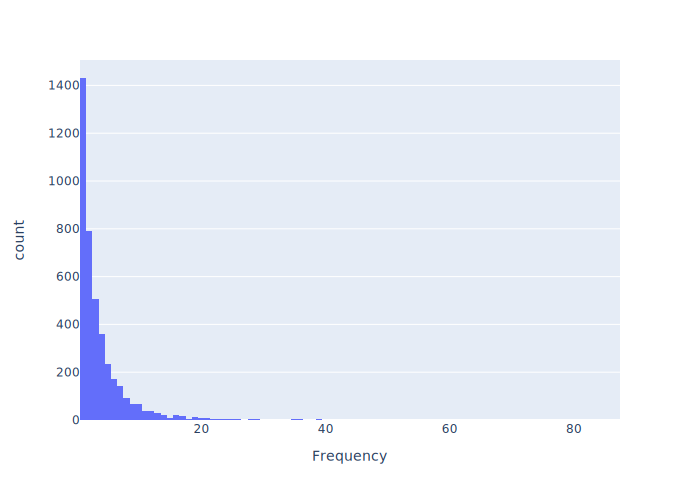

In [16]:
# The frequency varies a lot, so let's just see the ones lesser than 100
fig = px.histogram(data_frame=invoices_by_user.query('Frequency < 100'), x='Frequency')
fig.show('svg')

In [17]:
# For the sake of simplicity, let's use the same value of k (5) for this clusterization
kmeans = KMeans(n_clusters=5)
kmeans.fit(invoices_by_user[['Frequency']])
invoices_by_user['FrequencyCluster'] = kmeans.predict(invoices_by_user[['Frequency']])

In [18]:
# Before applying our sorting function...
invoices_by_user.groupby('FrequencyCluster').describe().xs('Frequency', axis=1)

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3317.0,2.147422,1.275276,1.0,1.0,2.0,3.00,5.0
1,14.0,64.928571,13.903316,45.0,53.0,64.0,78.50,87.0
2,692.0,8.682081,2.680275,6.0,7.0,8.0,10.00,16.0
3,5.0,127.000000,28.151377,102.0,103.0,121.0,140.00,169.0
4,92.0,24.184783,7.151315,17.0,19.0,21.0,28.25,43.0


In [19]:
# Applying func
invoices_by_user = sort_cluster(invoices_by_user, 'Frequency')

# ... and after!
invoices_by_user.groupby('FrequencyCluster').describe().xs('Frequency', axis=1)

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3317.0,2.147422,1.275276,1.0,1.0,2.0,3.00,5.0
1,692.0,8.682081,2.680275,6.0,7.0,8.0,10.00,16.0
2,92.0,24.184783,7.151315,17.0,19.0,21.0,28.25,43.0
3,14.0,64.928571,13.903316,45.0,53.0,64.0,78.50,87.0
4,5.0,127.000000,28.151377,102.0,103.0,121.0,140.00,169.0


So far so good. Next section, please.

___
- # Monetary value

How much money did the customer spend in a given period?

Again: the steps here are very similar to the ones in the previous sections.

In [20]:
monetary_to_merge = (
    invoices
    .groupby('Customer ID')
    ['Price']
    .sum()
    .rename('Monetary')
)   # creates a Series with the generated revenue per customer

invoices_by_user = invoices_by_user.merge(monetary_to_merge, left_on='CustomerID', right_on='Customer ID')

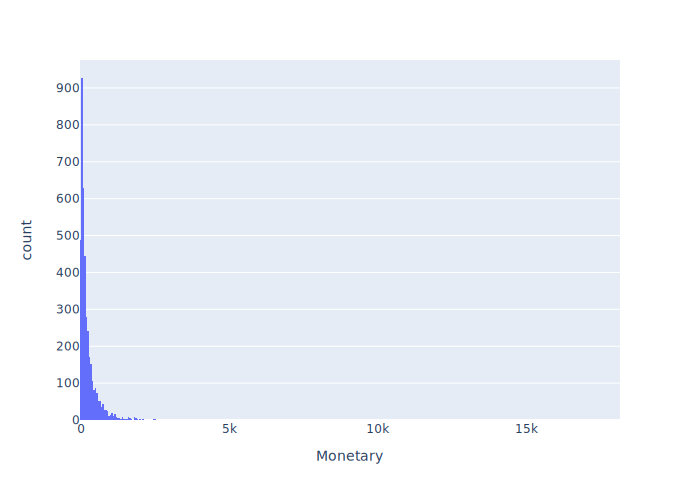

In [21]:
# Histogram plot
fig = px.histogram(data_frame=invoices_by_user, x='Monetary')
fig.show('svg')

In [22]:
# For the sake of simplicity, let's use the same value of k (5) for this clusterization
kmeans = KMeans(n_clusters=5)
kmeans.fit(invoices_by_user[['Monetary']])
invoices_by_user['MonetaryCluster'] = kmeans.predict(invoices_by_user[['Monetary']])

In [23]:
# Before applying our sorting function...
invoices_by_user.groupby('MonetaryCluster').describe().xs('Monetary', axis=1)

,count,mean,std,min,25%,50%,75%,max
MonetaryCluster,,,,,,,,
0,3334.0,119.742424,96.232201,0.19,42.2175,91.240,178.4525,375.02
1,9.0,6227.397778,1685.518563,4500.62,4789.0700,5896.010,6647.4500,9538.48
2,92.0,1831.744783,578.841043,1237.60,1422.6100,1660.475,1917.5050,3939.78
3,2.0,15500.865000,3652.369159,12918.25,14209.5575,15500.865,16792.1725,18083.48
4,683.0,633.126003,211.133083,375.35,465.4150,573.520,760.6500,1221.19


In [24]:
# Applying func
invoices_by_user = sort_cluster(invoices_by_user, 'Monetary')

# ... and after!
invoices_by_user.groupby('MonetaryCluster').describe().xs('Monetary', axis=1)

,count,mean,std,min,25%,50%,75%,max
MonetaryCluster,,,,,,,,
0,3334.0,119.742424,96.232201,0.19,42.2175,91.240,178.4525,375.02
1,683.0,633.126003,211.133083,375.35,465.4150,573.520,760.6500,1221.19
2,92.0,1831.744783,578.841043,1237.60,1422.6100,1660.475,1917.5050,3939.78
3,9.0,6227.397778,1685.518563,4500.62,4789.0700,5896.010,6647.4500,9538.48
4,2.0,15500.865000,3652.369159,12918.25,14209.5575,15500.865,16792.1725,18083.48


Super!

___
- # General overview

For a general analysis, we can simply assign a score to each customer, by summing up all of their clusters.

Naturally, the highest the score, the better.

We can also see how Recency, Frequency and Monetary values behave (the values itself, not their clusters!).

In [25]:
invoices_by_user['Score'] = invoices_by_user['RecencyCluster'] + invoices_by_user['FrequencyCluster'] + invoices_by_user['MonetaryCluster']

invoices_by_user.groupby('Score').agg(
    Count = pd.NamedAgg('Recency', 'count'),
    RecencyMean = pd.NamedAgg('Recency', 'mean'),
    FrequencyMean = pd.NamedAgg('Frequency', 'mean'),
    MonetaryMean = pd.NamedAgg('Monetary', 'mean')
)

,Count,RecencyMean,FrequencyMean,MonetaryMean
Score,,,,
0,382,282.057592,1.151832,68.638770
1,438,202.917808,1.543379,88.927671
2,550,129.563636,2.040000,124.371745
3,825,66.317576,2.389091,142.968570
4,1122,23.642602,2.949198,183.851533
5,366,23.912568,6.882514,398.877486
6,303,12.930693,10.069307,696.851287
7,78,10.884615,16.666667,1261.887051
8,39,7.153846,30.179487,1801.225897


Whoa, don't ever let those customers with score 8+ leave you!

We can go further and group these customers (once again) according to their scores:

|       | Label   |
|-------|---------|
| 0-3   | Low     |
| 4-7   | Mid     |
| 8-12  | High    |

In [26]:
invoices_by_user['Segment'] = 'Low'
invoices_by_user.loc[invoices_by_user['Score'] > 3,'Segment'] = 'Mid' 
invoices_by_user.loc[invoices_by_user['Score'] > 7,'Segment'] = 'High'

How would all these data look in a graph?

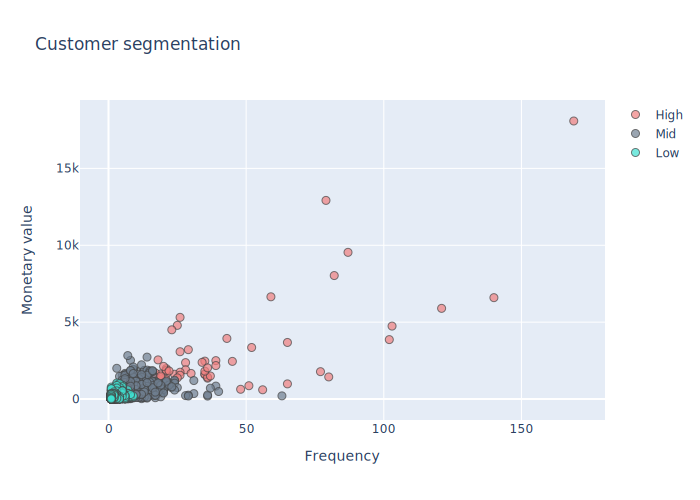

In [27]:
# Monetary value vs Frequency

plot_data = [
        go.Scatter(
        x=invoices_by_user.query("Segment == 'High'")['Frequency'],
        y=invoices_by_user.query("Segment == 'High'")['Monetary'],
        mode='markers',
        name='High',
        marker_size=8,
        marker_line_width=1,
        marker_color='lightcoral',
        marker_opacity=0.7
        ),
        go.Scatter(
        x=invoices_by_user.query("Segment == 'Mid'")['Frequency'],
        y=invoices_by_user.query("Segment == 'Mid'")['Monetary'],
        mode='markers',
        name='Mid',
        marker_size=8,
        marker_line_width=1,
        marker_color='slategray',
        marker_opacity=0.7
        ),
        go.Scatter(
        x=invoices_by_user.query("Segment == 'Low'")['Frequency'],
        y=invoices_by_user.query("Segment == 'Low'")['Monetary'],
        mode='markers',
        name='Low',
        marker_size=8,
        marker_line_width=1,
        marker_color='turquoise',
        marker_opacity=0.7
        )
]

plot_layout = go.Layout(
        yaxis= {'title': "Monetary value"},
        xaxis= {'title': "Frequency"},
        title='Customer segmentation'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show('svg')

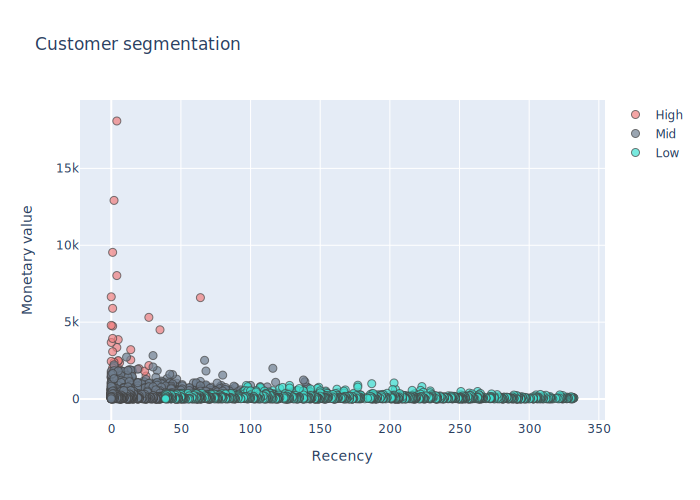

In [28]:
# Monetary value vs Recency

plot_data = [
        go.Scatter(
        x=invoices_by_user.query("Segment == 'High'")['Recency'],
        y=invoices_by_user.query("Segment == 'High'")['Monetary'],
        mode='markers',
        name='High',
        marker_size=8,
        marker_line_width=1,
        marker_color='lightcoral',
        marker_opacity=0.7
        ),
        go.Scatter(
        x=invoices_by_user.query("Segment == 'Mid'")['Recency'],
        y=invoices_by_user.query("Segment == 'Mid'")['Monetary'],
        mode='markers',
        name='Mid',
        marker_size=8,
        marker_line_width=1,
        marker_color='slategray',
        marker_opacity=0.7
        ),
        go.Scatter(
        x=invoices_by_user.query("Segment == 'Low'")['Recency'],
        y=invoices_by_user.query("Segment == 'Low'")['Monetary'],
        mode='markers',
        name='Low',
        marker_size=8,
        marker_line_width=1,
        marker_color='turquoise',
        marker_opacity=0.7
        )
]

plot_layout = go.Layout(
        yaxis= {'title': "Monetary value"},
        xaxis= {'title': "Recency"},
        title='Customer segmentation'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show('svg')

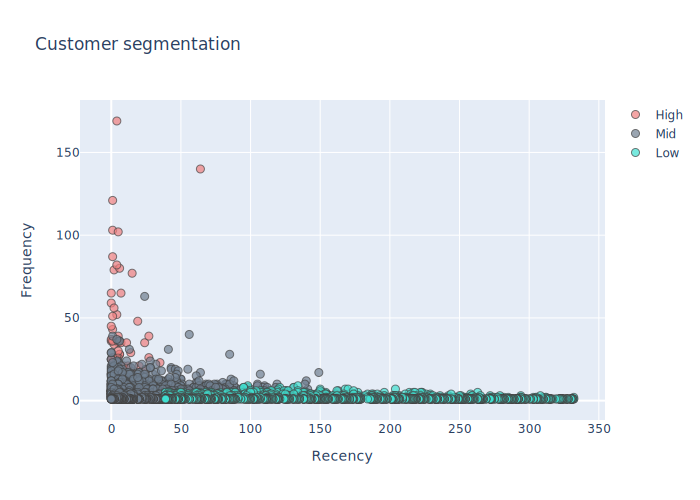

In [29]:
# Frequency vs Recency

plot_data = [
        go.Scatter(
        x=invoices_by_user.query("Segment == 'High'")['Recency'],
        y=invoices_by_user.query("Segment == 'High'")['Frequency'],
        mode='markers',
        name='High',
        marker_size=8,
        marker_line_width=1,
        marker_color='lightcoral',
        marker_opacity=0.7
        ),
        go.Scatter(
        x=invoices_by_user.query("Segment == 'Mid'")['Recency'],
        y=invoices_by_user.query("Segment == 'Mid'")['Frequency'],
        mode='markers',
        name='Mid',
        marker_size=8,
        marker_line_width=1,
        marker_color='slategray',
        marker_opacity=0.7
        ),
        go.Scatter(
        x=invoices_by_user.query("Segment == 'Low'")['Recency'],
        y=invoices_by_user.query("Segment == 'Low'")['Frequency'],
        mode='markers',
        name='Low',
        marker_size=8,
        marker_line_width=1,
        marker_color='turquoise',
        marker_opacity=0.7
        )
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Customer segmentation'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show('svg')

Now the marketing team can get their hands dirty! The main approaches here are quite clear:
- High-value: increase retention;
- Mid-value: increase retention and frequency;
- Low-value: increase frequency.

An in-depth analysis can help us identify profitable segments.

[This article](https://www.barilliance.com/rfm-analysis/#tab-con-3) from [Barilliance](https://www.barilliance.com/) has a very thorough description of different types of segments that can be extracted from our previously assigned clusters, for all 3 RFM sections.

I highly suggest you check it out.

___
And there goes another section, phew!

Next steps:
- Add all relevant functions from this notebook (specially the ones for plotting stuff) into `utils.py`;
- Add all visualizations from this notebook into our Streamlit app.

See you soon!